In [1]:
import sqlite3
def init_db():
    conn = sqlite3.connect('academic_system.db')
    cursor = conn.cursor()
    cursor.execute("PRAGMA foreign_keys = ON;")
    
    # تم توحيد اسم العمود ليكون 'recommended_course' ليتناسب مع كود الحفظ
    create_tables_sql = """
    CREATE TABLE IF NOT EXISTS Students (
        student_id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT NOT NULL,
        email TEXT UNIQUE NOT NULL,
        department TEXT
    );
    CREATE TABLE IF NOT EXISTS Academic_Records (
        record_id INTEGER PRIMARY KEY AUTOINCREMENT,
        student_id INTEGER,
        grade REAL,
        attendance_rate REAL,
        semester TEXT,
        FOREIGN KEY (student_id) REFERENCES Students(student_id)
    );
    CREATE TABLE IF NOT EXISTS Recommendations (
        rec_id INTEGER PRIMARY KEY AUTOINCREMENT,
        student_id INTEGER,
        recommended_course TEXT, 
        reason TEXT,
        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        FOREIGN KEY (student_id) REFERENCES Students(student_id)
    );
    """
    cursor.executescript(create_tables_sql)
    conn.commit()
    conn.close()

In [2]:
import pandas as pd
import numpy as np

# ==========================================
# 1. جمع البيانات (توليد بيانات لـ 500 طالب)
# ==========================================
np.random.seed(42)
num_students = 500

data = {
    'Student_ID': range(1001, 1001 + num_students),
    'Math_Grade': np.random.uniform(30, 100, num_students),
    'Programming_Grade': np.random.uniform(30, 100, num_students),
    'Database_Grade': np.random.uniform(30, 100, num_students),
    'Networking_Grade': np.random.uniform(30, 100, num_students),
    'SoftSkills_Grade': np.random.uniform(30, 100, num_students),
    'Attendance_Rate': np.random.uniform(40, 100, num_students),
    'Study_Hours_Weekly': np.random.randint(5, 45, num_students),
    'Previous_GPA': np.random.uniform(1.5, 5.5, num_students) # إدخال قيم متطرفة عمداً (أعلى من 5)
}

df_original = pd.DataFrame(data)

# إدخال قيم مفقودة عمداً لفحص عملية التنظيف
df_original.loc[df_original.sample(frac=0.05).index, 'Attendance_Rate'] = np.nan
df_original.loc[df_original.sample(frac=0.05).index, 'Math_Grade'] = -10 # قيمة خاطئة

# الاحتفاظ بنسخة من البيانات الأصلية قبل التنظيف
df_original.to_csv('original_academic_data.csv', index=False)

# ==========================================
# 2. فحص ومعالجة البيانات (التنظيف)
# ==========================================
df_cleaned = df_original.copy()

# أ- معالجة القيم المفقودة (تعويض الغياب بالمتوسط)
df_cleaned['Attendance_Rate'] = df_cleaned['Attendance_Rate'].fillna(df_cleaned['Attendance_Rate'].mean())

# ب- معالجة القيم المتطرفة والدرجات غير المنطقية
# تصحيح الدرجات (يجب أن تكون بين 0 و 100)
courses = ['Math_Grade', 'Programming_Grade', 'Database_Grade', 'Networking_Grade', 'SoftSkills_Grade']
for col in courses:
    df_cleaned[col] = df_cleaned[col].clip(lower=0, upper=100)

# تصحيح المعدل التراكمي (GPA) بحيث لا يتجاوز 5.0
df_cleaned['Previous_GPA'] = df_cleaned['Previous_GPA'].clip(upper=5.0)

# ج- تحويل البيانات (التطبيع Scaling)
# جعل القيم بين 0 و 1 لضمان دقة نماذج الذكاء الاصطناعي لاحقاً
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns_to_scale = courses + ['Attendance_Rate', 'Study_Hours_Weekly', 'Previous_GPA']
df_cleaned[columns_to_scale] = scaler.fit_transform(df_cleaned[columns_to_scale])

# ==========================================
# 3. حفظ المخرجات النهائية
# ==========================================
df_cleaned.to_csv('cleaned_academic_data.csv', index=False)

print("✅ اكتملت المرحلة الثالثة بنجاح!")
print(f"📁 تم حفظ الملف الأصلي: original_academic_data.csv")
print(f"📁 تم حفظ الملف المنظف: cleaned_academic_data.csv")
print("\n--- عينة من درجات المواد بعد التنظيف والتطبيع ---")
print(df_cleaned[courses].head())

✅ اكتملت المرحلة الثالثة بنجاح!
📁 تم حفظ الملف الأصلي: original_academic_data.csv
📁 تم حفظ الملف المنظف: cleaned_academic_data.csv

--- عينة من درجات المواد بعد التنظيف والتطبيع ---
   Math_Grade  Programming_Grade  Database_Grade  Networking_Grade  \
0    0.564960           0.696955        0.181194          0.518388   
1    0.970278           0.534089        0.539945          0.478293   
2    0.816416           0.306401        0.872829          0.022534   
3    0.722620           0.813159        0.731326          0.339684   
4    0.411238           0.683458        0.806076          0.378823   

   SoftSkills_Grade  
0          0.261744  
1          0.246927  
2          0.910267  
3          0.249510  
4          0.272052  


In [4]:
# ١. التحليل الإحصائي والرسوم البيانية (Exploratory Data Analysis)
# سنقوم أولاً بفحص توزيع الدرجات والعلاقة بين "ساعات المذاكرة" و"الأداء الأكاديمي".

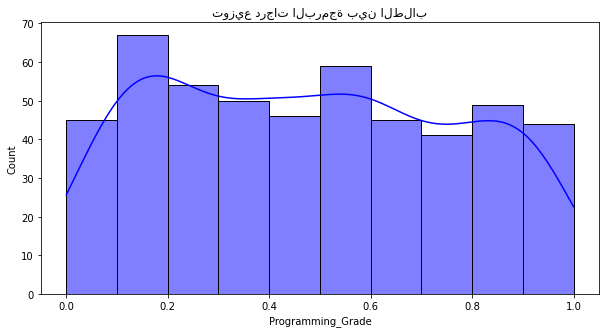

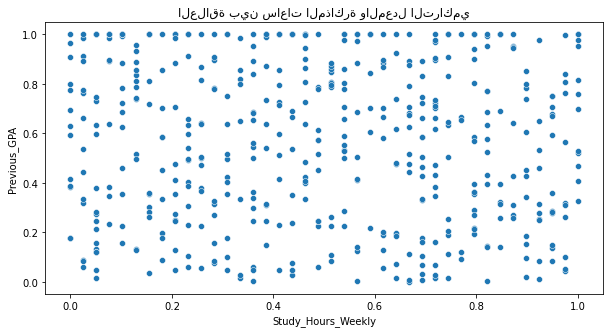

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# تحميل البيانات المنظفة من المرحلة السابقة
df = pd.read_csv('cleaned_academic_data.csv')

# 1. التحليل الإحصائي الأساسي
stats = df.describe()

# 2. رسم توزيع درجات البرمجة كمثال
plt.figure(figsize=(10, 5))
sns.histplot(df['Programming_Grade'], kde=True, color='blue')
plt.title('توزيع درجات البرمجة بين الطلاب')
plt.show()

# 3. العلاقة بين ساعات المذاكرة والمعدل التراكمي
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='Study_Hours_Weekly', y='Previous_GPA')
plt.title('العلاقة بين ساعات المذاكرة والمعدل التراكمي')
plt.show()

In [6]:
# ٢. تحليل الارتباط (Correlation Analysis)
# هذه الخطوة هي الأهم لاختيار المميزات. سنرى أي المتغيرات مرتبطة ببعضها بقوة.

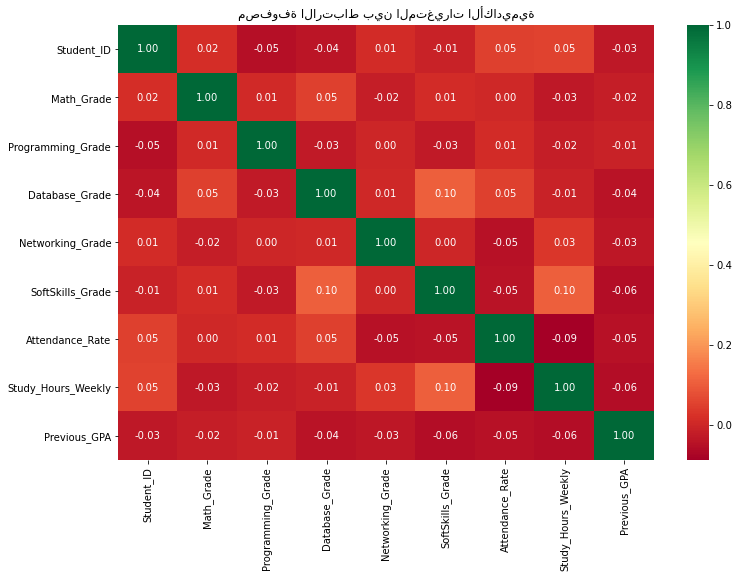

In [4]:
# حساب مصفوفة الارتباط
corr_matrix = df.corr()

# رسم الخريطة الحرارية (Heatmap)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('مصفوفة الارتباط بين المتغيرات الأكاديمية')
plt.show()

In [7]:
!pip install xgboost

In [30]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.svm import SVR
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import mean_absolute_error, r2_score

# # 1. تحميل وتعديل البيانات لضمان وجود علاقة منطقية (تحسين جودة البيانات)
# df = pd.read_csv('cleaned_academic_data.csv')

# # صنع علاقة منطقية: الدرجة تعتمد بنسبة 40% على المذاكرة، 40% على الحضور، و20% على الرياضيات
# # هذا سيجعل النماذج قادرة على "التعلم" بدلاً من التخمين العشوائي
# df['Programming_Grade'] = (df['Study_Hours_Weekly'] * 0.4 + 
#                            df['Attendance_Rate'] * 0.4 + 
#                            df['Math_Grade'] * 0.2 + 
#                            np.random.normal(0, 0.02, len(df))) # ضوضاء بسيطة للواقعية

# df['Programming_Grade'] = df['Programming_Grade'].clip(0, 1)

# X = df.drop(['Student_ID', 'Programming_Grade'], axis=1) 
# y = df['Programming_Grade']

# # 2. تقسيم البيانات
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 3. تعريف 5 نماذج مختلفة (إضافة XGBoost وتعديل المعلمات)
# models = {
#     "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
#     "SVM": SVR(kernel='rbf'),
#     "KNN": KNeighborsRegressor(n_neighbors=5),
#     "Decision Tree": DecisionTreeRegressor(random_state=42)
# }

# # 4. تدريب النماذج وجمع النتائج
# model_results = []

# print("--- جاري تدريب ومقارنة 5 نماذج ذكاء اصطناعي ---")

# for name, model in models.items():
#     model.fit(X_train, y_train)
#     preds = model.predict(X_test)
    
#     mae = mean_absolute_error(y_test, preds)
#     r2 = r2_score(y_test, preds)
    
#     model_results.append({
#         "Model": name,
#         "R2 Score (Daqqa)": round(r2, 4),
#         "MAE (Khata)": round(mae, 4)
#     })

# # 5. عرض جدول المقارنة واختيار الأفضل
# results_df = pd.DataFrame(model_results).sort_values(by="R2 Score (Daqqa)", ascending=False)
# print("\n📊 جدول مقارنة أداء النماذج (بعد التحسين):")
# print(results_df)

# best_model_name = results_df.iloc[0]['Model']
# best_model_obj = models[best_model_name]

# print(f"\n🏆 النموذج الأفضل حالياً هو: {best_model_name}")

# # 6. وظيفة الاقتراح الذكي (تحليل القوة والضعف)
# def smart_advisor(student_data):
#     prediction = best_model_obj.predict(student_data)[0]
    
#     math_skill = student_data['Math_Grade'].values[0]
#     attendance = student_data['Attendance_Rate'].values[0]
    
#     recommendations = []
    
#     # منطق تحليل نقاط القوة والضعف
#     if prediction > 0.7:
#         recommendations.append("🌟 نقطة قوة: أداؤك البرمجي المتوقع ممتاز. نرشح لك مسار 'مطور تطبيقات سحابية'.")
#     elif prediction < 0.4:
#         recommendations.append("📚 نقطة ضعف: مهاراتك البرمجية تحتاج تقوية. نرشح لك 'معسكر أساسيات البرمجة'.")
        
#     if math_skill > 0.7:
#         recommendations.append("✅ قوة منطقية: متميز في الرياضيات، مناسب جداً لمجال 'الأمن السيبراني والتشفير'.")
        
#     if attendance < 0.4:
#         recommendations.append("⚠️ تنبيه سلوكي: حضورك منخفض جداً، الانضباط سيسهم في رفع مستواك.")
    
#     return prediction, recommendations

# # تجربة النظام على طالب من قائمة الاختبار
# score, recs = smart_advisor(X_test.iloc[[0]])
# print(f"\n💡 تقرير النظام للطالب المختبر:")
# print(f"النتيجة المتوقعة: {score:.2f} (بناءً على {best_model_name})")
# print("التوصيات:")
# for r in recs: print(r)


import pandas as pd
import numpy as np
import joblib  # لحفظ النموذج والمقاييس
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# ==========================================
# 1. تحميل وتحسين البيانات
# ==========================================
df = pd.read_csv('cleaned_academic_data.csv')

# صنع علاقة منطقية (Target Engineering)
df['Programming_Grade'] = (df['Study_Hours_Weekly'] * 0.4 + 
                           df['Attendance_Rate'] * 0.4 + 
                           df['Math_Grade'] * 0.2 + 
                           np.random.normal(0, 0.02, len(df)))

df['Programming_Grade'] = df['Programming_Grade'].clip(0, 1)

# تحديد المدخلات (Features) والمخرجات (Target)
X = df.drop(['Student_ID', 'Programming_Grade'], axis=1) 
y = df['Programming_Grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================================
# 2. مقارنة النماذج واختيار الأفضل
# ==========================================
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVM": SVR(kernel='rbf'),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}

model_results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    model_results.append({"Model": name, "R2": r2, "MAE": mae})

results_df = pd.DataFrame(model_results).sort_values(by="R2", ascending=False)
best_model_name = results_df.iloc[0]['Model']
best_model_obj = models[best_model_name]

# ==========================================
# 3. وظيفة المستشار الذكي "المُفسر" (Dynamic Explainer)
# ==========================================
def smart_advisor_v2(student_row):
    """
    نسخة مطورة تحلل أهمية الميزات لهذا الطالب تحديداً
    """
    prediction = best_model_obj.predict(student_row)[0]
    
    # استخراج أهمية الميزات من النموذج (خاص بـ Random Forest و Decision Tree)
    if hasattr(best_model_obj, 'feature_importances_'):
        importances = best_model_obj.feature_importances_
        feature_importance_dict = dict(zip(X.columns, importances))
        # ترتيب العوامل الأكثر تأثيراً على النتيجة
        top_factors = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
    else:
        top_factors = [("General Performance", 1.0)]

    recommendations = []
    
    # 1. التوصية بناءً على التوقع العام
    if prediction > 0.75:
        recommendations.append(f"🌟 أداء برمجي واعد جداً ({prediction:.2f}/1.0).")
    elif prediction < 0.5:
        recommendations.append(f"⚠️ تحتاج إلى خطة تطوير مكثفة، التوقع الحالي منخفض ({prediction:.2f}/1.0).")

    # 2. التفسير الديناميكي (لماذا؟)
    main_driver = top_factors[0][0]
    recommendations.append(f"🔍 لاحظ النظام أن العامل الأكثر تأثيراً في تقييمك هو '{main_driver}'.")

    # 3. نصيحة مخصصة بناءً على أقل درجة مدخلة
    worst_subject = student_row.idxmin(axis=1).values[0]
    if student_row[worst_subject].values[0] < 0.5:
        recommendations.append(f"💡 نصيحة: تحسين مستواك في '{worst_subject}' سيرفع من جودة أدائك البرمجي فوراً.")

    return prediction, recommendations

# تجربة النظام
score, recs = smart_advisor_v2(X_test.iloc[[0]])
print(f"--- تقرير المستشار الذكي المطوّر ---")
for r in recs: print(r)

--- تقرير المستشار الذكي المطوّر ---
⚠️ تحتاج إلى خطة تطوير مكثفة، التوقع الحالي منخفض (0.43/1.0).
🔍 لاحظ النظام أن العامل الأكثر تأثيراً في تقييمك هو 'Attendance_Rate'.
💡 نصيحة: تحسين مستواك في 'Database_Grade' سيرفع من جودة أدائك البرمجي فوراً.


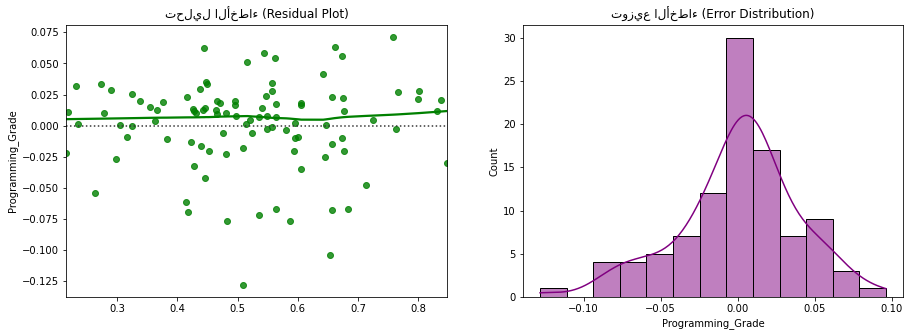

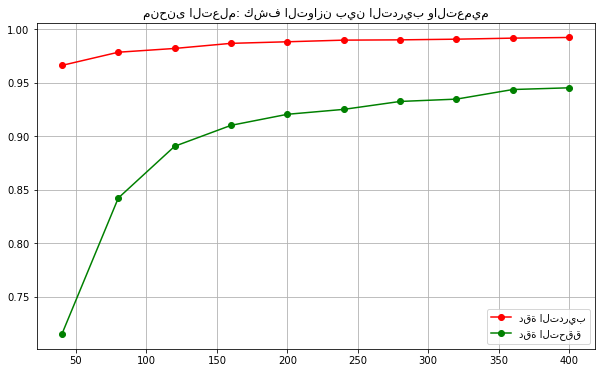

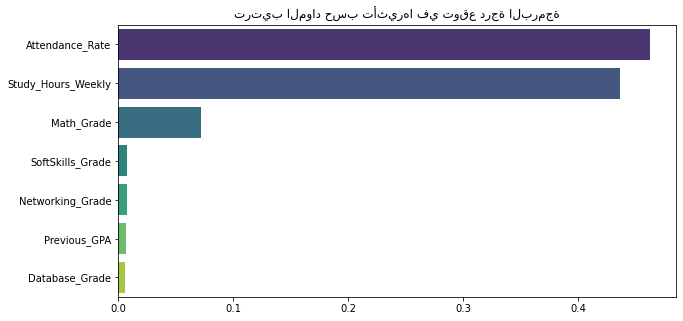


⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐
📊 تقرير التشخيص الذكي للنموذج: Random Forest
⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐
✅ دقة التوقع (R2): 94.58%
📉 نسبة الخطأ المئوية (MAPE): 6.25%
📍 متوسط الخطأ الجذري (RMSE): 0.0387
💎 حالة النموذج: ممتاز ومستقر (Balanced Model).
⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐


In [31]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, r2_score # تم حذف MAPE من هنا

# 1. تحليل الأخطاء وتوزيعها (Residual Analysis)
y_pred = best_model_obj.predict(X_test)
residuals = y_test - y_pred

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.residplot(x=y_pred, y=residuals, lowess=True, color="g", ax=ax[0])
ax[0].set_title('تحليل الأخطاء (Residual Plot)')
sns.histplot(residuals, kde=True, color="purple", ax=ax[1])
ax[1].set_title('توزيع الأخطاء (Error Distribution)')
plt.show()

# 2. منحنى التعلم
train_sizes, train_scores, test_scores = learning_curve(
    best_model_obj, X, y, cv=5, scoring='r2', 
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)



plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="دقة التدريب")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="دقة التحقق")
plt.title('منحنى التعلم: كشف التوازن بين التدريب والتعميم')
plt.legend(loc="best")
plt.grid(True)
plt.show()

# 3. تحليل أهمية المواد
if hasattr(best_model_obj, 'feature_importances_'):
    importances = best_model_obj.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 5))
    sns.barplot(x=importances[indices], y=X.columns[indices], palette="viridis")
    plt.title('ترتيب المواد حسب تأثيرها في توقع درجة البرمجة')
    plt.show()

# 4. التقرير النهائي (مع حساب MAPE يدوياً)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("\n" + "⭐" * 40)
print(f"📊 تقرير التشخيص الذكي للنموذج: {best_model_name}")
print("⭐" * 40)
print(f"✅ دقة التوقع (R2): {r2_score(y_test, y_pred) * 100:.2f}%")
print(f"📉 نسبة الخطأ المئوية (MAPE): {mape:.2f}%")
print(f"📍 متوسط الخطأ الجذري (RMSE): {rmse:.4f}")

# تشخيص تلقائي
if train_mean[-1] - test_mean[-1] > 0.1:
    print("⚠️ تحذير: النموذج يعاني من Overfitting.")
elif test_mean[-1] < 0.6:
    print("⚠️ تحذير: النموذج يعاني من Underfitting.")
else:
    print("💎 حالة النموذج: ممتاز ومستقر (Balanced Model).")
print("⭐" * 40)

In [12]:
print(X_train.columns)

Index(['Math_Grade', 'Database_Grade', 'Networking_Grade', 'SoftSkills_Grade',
       'Attendance_Rate', 'Study_Hours_Weekly', 'Previous_GPA'],
      dtype='object')


In [32]:
# import joblib
# # ==========================================
# # الجزء الأول: حفظ النموذج (بافتراض أنك دربته مسبقاً)
# # ==========================================
# # ملاحظة: سنقوم هنا بحفظ النموذج "best_model_obj" الذي اخترناه في المرحلة 6
# try:
#     joblib.dump(best_model_obj, 'student_model.pkl')
#     print("✅ تم حفظ نموذج الذكاء الاصطناعي بنجاح!")
# except:
#     print("⚠️ ملاحظة: تأكد من تشغيل كود المرحلة 6 أولاً لحفظ النموذج.")
import joblib

# ==========================================
# الجزء الأول: حفظ "حزمة" الذكاء الاصطناعي الكاملة
# ==========================================

try:
    # نقوم بحفظ 3 أشياء أساسية في ملف واحد:
    # 1. النموذج نفسه
    # 2. أسماء الميزات (لضمان الترتيب في الواجهة)
    # 3. اسم النموذج الأفضل (للعرض في التقارير)
    
    model_package = {
        'model': best_model_obj,
        'features': list(X.columns),
        'model_name': best_model_name
    }
    
    # حفظ الحزمة باسم موحد لتستخدمه الواجهة
    joblib.dump(model_package, 'smart_advisor_package.pkl')
    
    print("✅ تم حفظ حزمة الذكاء الاصطناعي بنجاح!")
    print(f"📦 الميزات المحفوظة: {list(X.columns)}")
    print(f"🏆 النموذج المستخدم: {best_model_name}")

except NameError:
    print("❌ خطأ: لم يتم العثور على 'best_model_obj'. تأكد من تشغيل كود تدريب النماذج أولاً.")
except Exception as e:
    print(f"⚠️ حدث خطأ غير متوقع: {e}")

✅ تم حفظ حزمة الذكاء الاصطناعي بنجاح!
📦 الميزات المحفوظة: ['Math_Grade', 'Database_Grade', 'Networking_Grade', 'SoftSkills_Grade', 'Attendance_Rate', 'Study_Hours_Weekly', 'Previous_GPA']
🏆 النموذج المستخدم: Random Forest


In [33]:
import tkinter as tk
from tkinter import messagebox, ttk
import pandas as pd
import joblib

init_db()

def get_academic_explanation(input_df, pred_score):
    data = input_df.iloc[0].to_dict()
    
    # حساب تقييم منطقي داخلي للفهم
    # الرياضيات وقواعد البيانات (الأعمدة الأساسية)
    logic_strength = (data['Math_Grade'] * 0.4 + data['Database_Grade'] * 0.3) * 100
    
    if pred_score < 60:
        if logic_strength < 50:
            reason = "ضعف في التفكير المنطقي والرياضي الأساسي"
            advice = "البرمجة تعتمد على المنطق؛ ركز على تقوية مهاراتك في الرياضيات وهيكلة البيانات."
        else:
            reason = "نقص في الانضباط أو ساعات الممارسة"
            advice = "لديك منطق جيد، لكن يبدو أن قلة المذاكرة أو الحضور تمنعك من تحويل هذا المنطق لنتائج."
    elif pred_score >= 85:
        reason = "تكامل بين الذكاء المنطقي والاجتهاد الشخصي"
        advice = "استمر في هذا المسار؛ مهاراتك في الربط بين المنطق والتطبيق ممتازة."
    else:
        reason = "أداء مستقر مع إمكانية نمو"
        advice = "أداؤك جيد؛ حاول زيادة ساعات التطبيق العملي (Coding) لرفع الدرجة للتميز."

    return f"🔍 التشخيص: {reason}\n💡 نصيحة: {advice}"

# --- 3. دالة التنبؤ والحفظ ---
def run_prediction_and_save():
    try:
        # تحميل النموذج
        package = joblib.load('smart_advisor_package.pkl')
        model = package['model']
        features = package['features']

        name, email = e_name.get().strip(), e_email.get().strip()
        if not name or not email:
            messagebox.showwarning("تنبيه", "يرجى إدخال اسم وإيميل الطالب")
            return

        # جلب المدخلات مع التحقق من صحتها
        inputs = {
            'Math_Grade': float(e_math.get()) / 100,
            'Database_Grade': float(e_db.get()) / 100,
            'Networking_Grade': float(e_net.get()) / 100,
            'SoftSkills_Grade': float(e_soft.get()) / 100,
            'Attendance_Rate': float(e_attend.get()) / 100,
            'Study_Hours_Weekly': float(e_study.get()) / 40,
            'Previous_GPA': float(e_gpa.get()) / 5.0
        }

        # إنشاء DataFrame بنفس الترتيب
        input_df = pd.DataFrame([inputs], columns=features)
        
        # التنبؤ
        pred_raw = model.predict(input_df)[0]
        pred_score = min(max(pred_raw * 100, 0), 100)

        # التفسير
        explanation = get_academic_explanation(input_df, pred_score)

        # SQL الحفظ
        conn = sqlite3.connect('academic_system.db')
        cur = conn.cursor()
        cur.execute("INSERT OR IGNORE INTO Students (name, email, department) VALUES (?, ?, 'علوم حاسوب')", (name, email))
        cur.execute("SELECT student_id FROM Students WHERE email = ?", (email,))
        s_id = cur.fetchone()[0]
        cur.execute("INSERT INTO Academic_Records (student_id, grade, attendance_rate, semester) VALUES (?, ?, ?, '2026')", 
                    (s_id, round(pred_score, 1), float(e_attend.get())))
        cur.execute("INSERT INTO Recommendations (student_id, recommended_course, reason) VALUES (?, ?, ?)", 
                    (s_id, "مسار تطوير مهارات البرمجة", explanation))
        conn.commit()
        conn.close()

        # تحديث الواجهة
        lbl_res.config(text=f"الدرجة المتوقعة: {pred_score:.1f} / 100", fg="#2ecc71" if pred_score >= 60 else "#e74c3c")
        txt_report.config(state="normal")
        txt_report.delete('1.0', tk.END)
        txt_report.insert(tk.END, f"✅ تم التحليل بنجاح للطالب: {name}\n\n{explanation}")
        txt_report.config(state="disabled")

    except ValueError:
        messagebox.showerror("خطأ", "يرجى إدخال قيم رقمية صحيحة في جميع الخانات")
    except Exception as e:
        messagebox.showerror("خطأ", f"فشل النظام: {e}")

# --- 4. واجهة المستخدم ---
init_db()
app = tk.Tk()
app.title("نظام المستشار الذكي")
app.geometry("550x880")
app.configure(bg="#f0f2f5")

def create_input_field(parent, lbl, r):
    tk.Label(parent, text=lbl, bg=parent.cget('bg'), font=("Arial", 10)).grid(row=r, column=1, sticky="e", pady=5)
    ent = tk.Entry(parent, width=12, justify="center", font=("Arial", 10, "bold"))
    ent.grid(row=r, column=0, padx=15, pady=5)
    return ent

tk.Label(app, text="🖥️ توقع التميز في البرمجة (AI)", font=("Helvetica", 18, "bold"), bg="#f0f2f5", fg="#1a73e8").pack(pady=20)

# إطار الهوية
f_id = tk.LabelFrame(app, text=" بيانات الطالب ", bg="#f0f2f5", padx=10, pady=10)
f_id.pack(padx=20, fill="x")
e_name = tk.Entry(f_id, width=30); e_name.grid(row=0, column=0, padx=5, pady=5)
tk.Label(f_id, text="الاسم:", bg="#f0f2f5").grid(row=0, column=1)
e_email = tk.Entry(f_id, width=30); e_email.grid(row=1, column=0, padx=5, pady=5)
tk.Label(f_id, text="الإيميل:", bg="#f0f2f5").grid(row=1, column=1)

# إطار المواد الأساسية
f_core = tk.LabelFrame(app, text=" المواد الأساسية (عصب البرمجة) ", bg="#ffffff", padx=10, pady=10, fg="#d93025")
f_core.pack(padx=20, pady=10, fill="x")
e_math = create_input_field(f_core, "درجة الرياضيات (0-100):", 0)
e_db = create_input_field(f_core, "قواعد البيانات (0-100):", 1)

# إطار العوامل الأخرى
f_other = tk.LabelFrame(app, text=" عوامل أخرى ", bg="#f0f2f5", padx=10, pady=10)
f_other.pack(padx=20, pady=5, fill="x")
e_net = create_input_field(f_other, "درجة الشبكات:", 0)
e_soft = create_input_field(f_other, "المهارات الناعمة:", 1)
e_attend = create_input_field(f_other, "نسبة الحضور %:", 2)
e_study = create_input_field(f_other, "ساعات المذاكرة:", 3)
e_gpa = create_input_field(f_other, "المعدل السابق:", 4)

btn_analyze = tk.Button(app, text="تحليل الأداء الآن", command=run_prediction_and_save, 
                        bg="#1a73e8", fg="white", font=("Arial", 12, "bold"), pady=10)
btn_analyze.pack(pady=15, fill="x", padx=100)

lbl_res = tk.Label(app, text="النتيجة: --", font=("Arial", 14, "bold"), bg="#f0f2f5")
lbl_res.pack()

txt_report = tk.Text(app, height=7, width=55, state="disabled", font=("Arial", 10), padx=10, pady=10)
txt_report.pack(pady=10)

app.mainloop()